In [2]:
from timeit import default_timer as timer

In [3]:
def xor(s1, s2):
    return bytes(a ^ b for a, b in zip(s1, s2))


class AES(object):
    Gmul = {}

    def __init__(self, key):
        """
        The key expansion routine, as part of the overall AES algorithm,
        takes an input key (denoted key below) of
        4*Nk bytes, or Nk 32-bit words.
        Nk has value either 4, 6, or 8.
        The output is an expanded key (denoted w below) of 4*Nb*(Nr+1) bytes,
        where Nb is always 4 and Nr is the number of rounds in the algorithm,
        with
            Nr equal 10 in case Nk is 4,
            Nr equal 12 in case Nk is 6, and
            Nr equal 14 in case Nk is 8.
        """
        assert len(key)*8 in {128, 192, 256}, "invalid key length"
        self.nb = 4
        self.nk = len(key) // 4
        self.nr = {4: 10, 6: 12, 8: 14}[self.nk]
        self.state = bytearray()
        self.key = key
        
        self.byte_transfer_time_stamp = []
        self.key_schedule_time_stamp = []
        self.add_round_key_time_stamp = []
        self.sub_bytes_time_stamp = []
        self.shift_rows_time_stamp = []
        self.mix_columns_time_stamp = []
        
        self.inv_byte_transfer_time_stamp = []
        self.inv_key_schedule_time_stamp = []
        self.inv_add_round_key_time_stamp = []
        self.inv_sub_bytes_time_stamp = []
        self.inv_shift_rows_time_stamp = []
        self.inv_mix_columns_time_stamp = []
        
        if not AES.Gmul:
            for f in (0x02, 0x03, 0x0e, 0x0b, 0x0d, 0x09):
                AES.Gmul[f] = bytes(AES.gmul(f, x) for x in range(0, 0x100))

    Rcon = (0x8d, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1b, 0x36, 0x6c, 0xd8, 0xab, 0x4d, 0x9a)
    Sbox = (
        0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
        0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
        0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
        0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
        0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
        0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
        0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
        0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
        0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
        0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
        0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
        0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
        0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
        0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
        0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
        0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    )
    Sbox_inv = (
        0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
        0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
        0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
        0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
        0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
        0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
        0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
        0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
        0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
        0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
        0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
        0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
        0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
        0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
        0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
        0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D
    )

    @staticmethod
    def rot_word(word):
        return word[1:] + word[:1]

    @staticmethod
    def sub_word(word):
        return (AES.Sbox[b] for b in word)

    def key_schedule(self):
        expanded = bytearray()
        expanded.extend(self.key)
        for i in range(self.nk, self.nb * (self.nr + 1)):
            t = expanded[(i - 1) * 4:i * 4]
            if i % self.nk == 0:
                t = xor(AES.sub_word(AES.rot_word(t)), (AES.Rcon[i // self.nk], 0, 0, 0))
            elif self.nk > 6 and i % self.nk == 4:
                t = AES.sub_word(t)
            expanded.extend(xor(t, expanded[(i - self.nk) * 4:(i - self.nk + 1) * 4]))
        return expanded

    def add_round_key(self, rkey):
        for i, b in enumerate(rkey):
            self.state[i] ^= b

    def sub_bytes(self):
        for i, b in enumerate(self.state):
            self.state[i] = AES.Sbox[b]

    def inv_sub_bytes(self):
        for i, b in enumerate(self.state):
            self.state[i] = AES.Sbox_inv[b]

    def shift_rows(self):
        rows = []
        for r in range(4):
            rows.append(self.state[r::4])
            rows[r] = rows[r][r:] + rows[r][:r]
        self.state = [r[c] for c in range(4) for r in rows]

    def inv_shift_rows(self):
        rows = []
        for r in range(4):
            rows.append(self.state[r::4])
            rows[r] = rows[r][4 - r:] + rows[r][:4 - r]
        self.state = [r[c] for c in range(4) for r in rows]

    @staticmethod
    def gmul(a, b):
        p = 0
        for c in range(8):
            if b & 1:
                p ^= a
            a <<= 1
            if a & 0x100:
                a ^= 0x11b
            b >>= 1
        return p

    def mix_columns(self):
        ss = []
        for c in range(4):
            col = self.state[c * 4:(c + 1) * 4]
            ss.extend((
                AES.Gmul[0x02][col[0]] ^ AES.Gmul[0x03][col[1]] ^ col[2] ^ col[3],
                col[0] ^ AES.Gmul[0x02][col[1]] ^ AES.Gmul[0x03][col[2]] ^ col[3],
                col[0] ^ col[1] ^ AES.Gmul[0x02][col[2]] ^ AES.Gmul[0x03][col[3]],
                AES.Gmul[0x03][col[0]] ^ col[1] ^ col[2] ^ AES.Gmul[0x02][col[3]],
            ))
        self.state = ss

    def inv_mix_columns(self):
        ss = []
        for c in range(4):
            col = self.state[c * 4:(c + 1) * 4]
            ss.extend((
                AES.Gmul[0x0e][col[0]] ^ AES.Gmul[0x0b][col[1]] ^ AES.Gmul[0x0d][col[2]] ^ AES.Gmul[0x09][col[3]],
                AES.Gmul[0x09][col[0]] ^ AES.Gmul[0x0e][col[1]] ^ AES.Gmul[0x0b][col[2]] ^ AES.Gmul[0x0d][col[3]],
                AES.Gmul[0x0d][col[0]] ^ AES.Gmul[0x09][col[1]] ^ AES.Gmul[0x0e][col[2]] ^ AES.Gmul[0x0b][col[3]],
                AES.Gmul[0x0b][col[0]] ^ AES.Gmul[0x0d][col[1]] ^ AES.Gmul[0x09][col[2]] ^ AES.Gmul[0x0e][col[3]],
            ))
        self.state = ss

    def cipher(self, block):
        # print "round[ 0].input: {0}".format(block.encode('hex'))
        initial = timer()
        
        start = timer()
        n = self.nb * 4
        self.state = bytearray(block)
        end = timer()
        self.byte_transfer_time_stamp.append(end-start)
        
        #step1 key schedule
        start = timer()
        keys = self.key_schedule()
        end = timer()
        self.key_schedule_time_stamp.append(end-start)
        # print "round[ 0].k_sch: {0}".format(keys[0:n].encode('hex'))
        
        start = timer()
        self.add_round_key(keys[0:n])
        end = timer()
        self.add_round_key_time_stamp.append(end-start)
        
        for r in range(1, self.nr):
            # print "round[{0}].start: {1}".format(r,self.state.encode('hex'))
            start = timer()
            self.sub_bytes()
            end = timer()
            self.sub_bytes_time_stamp.append(end-start)
        
            # print "round[{0}].s_box: {1}".format(r,self.state.encode('hex'))
            start = timer()
            self.shift_rows()
            end = timer()
            self.shift_rows_time_stamp.append(end-start)
            
            # print "round[{0}].s_row: {1}".format(r,self.state.encode('hex'))
            start = timer()
            self.mix_columns()
            end = timer()
            self.mix_columns_time_stamp.append(end-start)
            
            # print "round[{0}].m_col: {1}".format(r,self.state.encode('hex'))
            start = timer()
            k = keys[r * n:(r + 1) * n]
            
            # print "round[{0}].k_sch: {1}".format(r,k.encode('hex'))
            self.add_round_key(k)
            end = timer()
            self.add_round_key_time_stamp.append(end-start)

        start = timer()
        self.sub_bytes()
        end = timer()
        self.sub_bytes_time_stamp.append(end-start)
        
        start = timer()
        self.shift_rows()
        end = timer()
        self.shift_rows_time_stamp.append(end-start)
        
        start = timer()
        self.add_round_key(keys[self.nr * n:])
        end = timer()
        self.add_round_key_time_stamp.append(end-start)
        
        final = timer()
        #print(self.add_round_key_time_stamp)
        # print "output: {0}".format(self.state.encode('hex'))
        
        time_stamp = {}
        time_stamp["bit_array"]= self.byte_transfer_time_stamp
        time_stamp["key_schedule"]= self.key_schedule_time_stamp 
        time_stamp["add_round_key"]= self.add_round_key_time_stamp
        time_stamp["sub_bytes"]= self.sub_bytes_time_stamp
        time_stamp["shift_rows"]= self.shift_rows_time_stamp
        time_stamp["cipher"]= [final-initial]    
        
        return bytes(self.state), time_stamp

    def inv_cipher(self, block):
        # print "round[ 0].iinput: {0}".format(block.encode('hex'))
        initial = timer()
        
        start = timer()
        n = self.nb * 4
        self.state = bytearray(block)
        end = timer()
        self.inv_byte_transfer_time_stamp.append(end-start)
        
        start = timer()
        keys = self.key_schedule()
        end = timer()
        self.inv_key_schedule_time_stamp.append(end-start)
        
        k = keys[self.nr * n:(self.nr + 1) * n]
        # print "round[ 0].ik_sch: {0}".format(k.encode('hex'))
        start = timer()
        self.add_round_key(k)
        end = timer()
        self.inv_add_round_key_time_stamp.append(end-start)
        
        for r in range(self.nr - 1, 0, -1):
            # print "round[{0}].istart: {1}".format(r,self.state.encode('hex'))
            start = timer()
            self.inv_shift_rows()
            end = timer()
            self.inv_shift_rows_time_stamp.append(end-start)
            
            # print "round[{0}].is_row: {1}".format(r,self.state.encode('hex'))
            start = timer()
            self.inv_sub_bytes()
            end = timer()
            self.inv_sub_bytes_time_stamp.append(end-start)
            
            # print "round[{0}].is_box: {1}".format(r,self.state.encode('hex'))
            start = timer()
            k = keys[r * n:(r + 1) * n]
            # print "round[{0}].ik_sch: {1}".format(r,k.encode('hex'))
            self.add_round_key(k)
            end = timer()
            self.inv_add_round_key_time_stamp.append(end-start)
            
            # print "round[{0}].ik_add: {1}".format(r,self.state.encode('hex'))
            start = timer()
            self.inv_mix_columns()
            end = timer()
            self.inv_mix_columns_time_stamp.append(end-start)
            # print "round[{0}].im_col: {1}".format(r,self.state.encode('hex'))

        start = timer()
        self.inv_shift_rows()
        end = timer()
        self.inv_shift_rows_time_stamp.append(end-start)
        
        start = timer()
        self.inv_sub_bytes()
        end = timer()
        self.inv_sub_bytes_time_stamp.append(end-start)
        
        start = timer()
        self.add_round_key(keys[0:n])
        end = timer()
        self.inv_add_round_key_time_stamp.append(end-start)
        # print "output: {0}".format(self.state.encode('hex'))
        final = timer()
        
        time_stamp = {}
        time_stamp["inv_bit_array"]= self.inv_byte_transfer_time_stamp
        time_stamp["inv_key_schedule"]= self.inv_key_schedule_time_stamp 
        time_stamp["inv_add_round_key"]= self.inv_add_round_key_time_stamp
        time_stamp["inv_sub_bytes"]= self.inv_sub_bytes_time_stamp
        time_stamp["inv_shift_rows"]= self.inv_shift_rows_time_stamp
        time_stamp["decipher"]= [final-initial]
        
        return bytes(self.state),time_stamp



        

In [4]:
if __name__ == "__main__":
    key = bytes.fromhex("2b7e151628aed2a6abf7158809cf4f3c")
    check = (
        ("6bc1bee22e409f96e93d7e117393172a", "3ad77bb40d7a3660a89ecaf32466ef97"),
        ("ae2d8a571e03ac9c9eb76fac45af8e51", "f5d3d58503b9699de785895a96fdbaaf"),
        ("30c81c46a35ce411e5fbc1191a0a52ef", "43b1cd7f598ece23881b00e3ed030688"),
        ("f69f2445df4f9b17ad2b417be66c3710", "7b0c785e27e8ad3f8223207104725dd4"),
    )
    crypt = AES(key)
    for clear_hex, encoded_hex in check:
        clear_bytes = bytes.fromhex(clear_hex)
        encoded_bytes = bytes.fromhex(encoded_hex)
        
        t,time_stamp = crypt.cipher(clear_bytes)
        
        if t == encoded_bytes:
            
            t,inv_time_stamp = crypt.inv_cipher(t)
            if t == clear_bytes:
                print("yay!",clear_hex,"and",encoded_hex,"are matched")
            else:
                print("{1} != {0}".format(t.hex(), clear_hex))
        else:
            print("{0} != {1}".format(t.hex(), encoded_hex))

yay! 6bc1bee22e409f96e93d7e117393172a and 3ad77bb40d7a3660a89ecaf32466ef97 are matched
yay! ae2d8a571e03ac9c9eb76fac45af8e51 and f5d3d58503b9699de785895a96fdbaaf are matched
yay! 30c81c46a35ce411e5fbc1191a0a52ef and 43b1cd7f598ece23881b00e3ed030688 are matched
yay! f69f2445df4f9b17ad2b417be66c3710 and 7b0c785e27e8ad3f8223207104725dd4 are matched


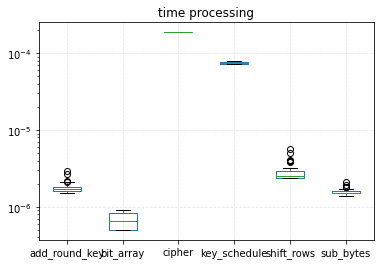

In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame()
for item in time_stamp.keys():   
    df1 = pd.DataFrame(time_stamp[item],columns=[item])
    df = pd.concat([df,df1],sort=True)
df.plot.box(title="time processing",logy=True)
plt.grid(linestyle="--", alpha=0.3)
plt.show()

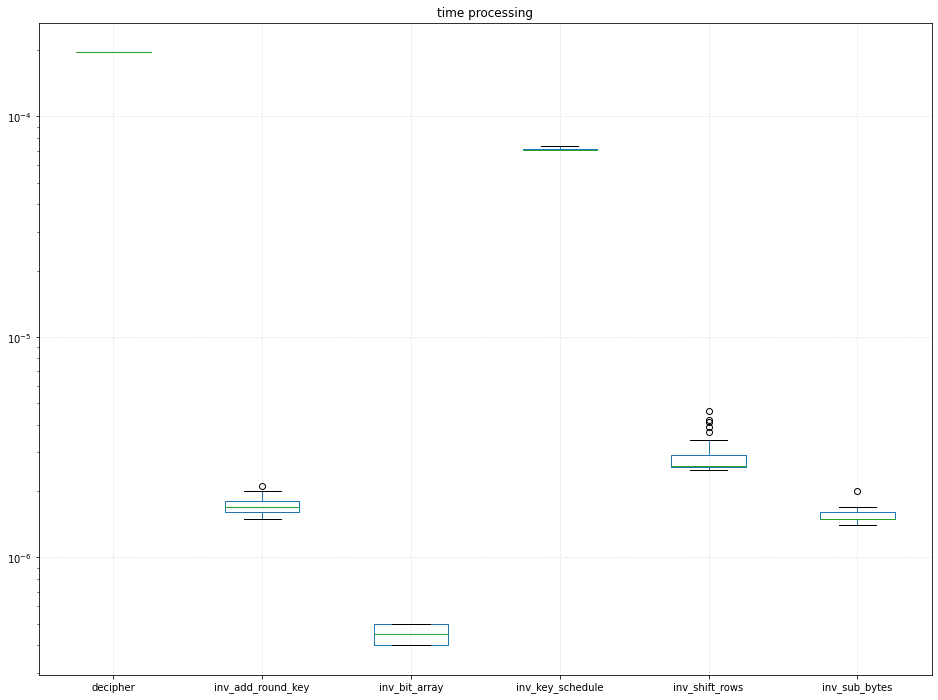

In [6]:
inv_df = pd.DataFrame()
for item in inv_time_stamp.keys():   
    inv_df1 = pd.DataFrame(inv_time_stamp[item],columns=[item])
    inv_df = pd.concat([inv_df,inv_df1],sort=True)
inv_df.plot.box(title="time processing",logy=True,figsize=(16,12))
plt.grid(linestyle="--", alpha=0.3)
plt.show()

In [7]:
from tqdm.notebook import tqdm

In [15]:
import os,binascii
num_AES_round = 5000
task_time = []

df = pd.DataFrame()
inv_df = pd.DataFrame()
for i in tqdm(range(num_AES_round)):
    start = timer()
    random_key =  binascii.b2a_hex(os.urandom(16))
    
    crypt = AES(random_key)
    clear_hex = binascii.b2a_hex(os.urandom(16))
    clear_bytes = clear_hex
    encoded_bytes ,time_stamp_cipher = crypt.cipher(clear_bytes)
    for item in time_stamp_cipher.keys():       
        df1 = pd.DataFrame(time_stamp_cipher[item],columns=[item])
        df = pd.concat([df,df1],sort=True)
    
    output,time_stamp_inv_cipher = crypt.inv_cipher(encoded_bytes)
    for item in time_stamp_inv_cipher.keys():       
        inv_df1 = pd.DataFrame(time_stamp_inv_cipher[item],columns=[item])
        inv_df = pd.concat([inv_df,inv_df1],sort=True)
        
    end = timer()
    task_time.append(end-start)
    if num_AES_round < 20:
        print("Pair", i,": plain string:",clear_hex,"coded string:",encoded_bytes.hex(),"Key:",random_key)

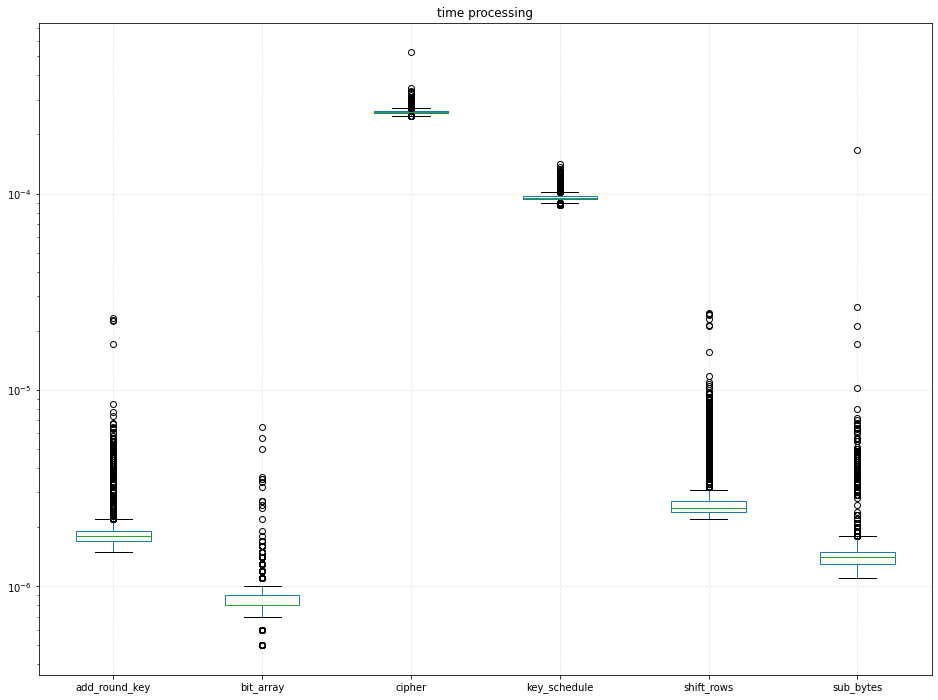

In [16]:
df.plot.box(title="time processing",logy=True,figsize=(16,12))
plt.grid(linestyle="--", alpha=0.3)
plt.show()

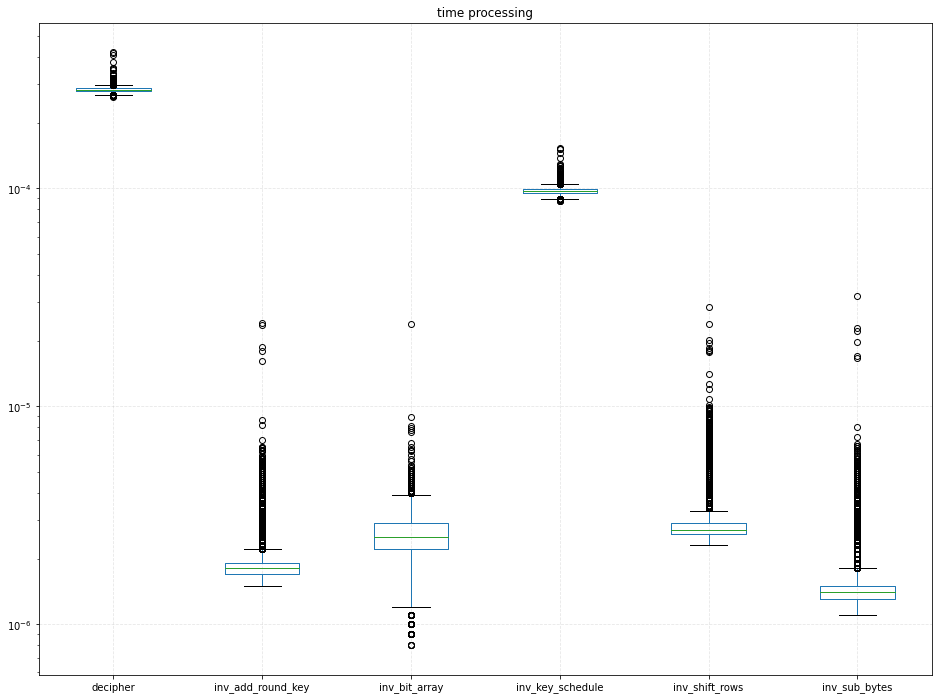

In [17]:
inv_df.plot.box(title="time processing",logy=True,figsize=(16,12))
plt.grid(linestyle="--", alpha=0.3)
plt.show()

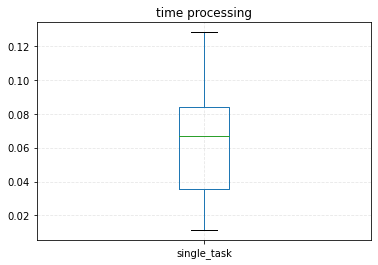

In [18]:
test_bench = pd.DataFrame(task_time,columns=["single_task"])
test_bench.plot.box(title="time processing",logy=0)
plt.grid(linestyle="--", alpha=0.3)
plt.show()

In [337]:
for items in time_stamp_cipher.keys():
    print(df[items].describe())

count    2.000000e+03
mean     9.158498e-07
std      2.649507e-07
min      4.999893e-07
25%      7.999915e-07
50%      8.999923e-07
75%      9.999931e-07
max      4.999994e-06
Name: bit_array, dtype: float64
count    2000.000000
mean        0.000097
std         0.000005
min         0.000087
25%         0.000095
50%         0.000097
75%         0.000099
max         0.000135
Name: key_schedule, dtype: float64
count    3.000000e+04
mean     1.903947e-06
std      5.773250e-07
min      1.499997e-06
25%      1.699998e-06
50%      1.799999e-06
75%      1.900000e-06
max      2.690000e-05
Name: add_round_key, dtype: float64
count    2.800000e+04
mean     1.525196e-06
std      6.206137e-07
min      1.099994e-06
25%      1.299995e-06
50%      1.300010e-06
75%      1.499997e-06
max      2.480000e-05
Name: sub_bytes, dtype: float64
count    28000.000000
mean         0.000003
std          0.000001
min          0.000002
25%          0.000002
50%          0.000003
75%          0.000003
max          0.

In [338]:
for items in time_stamp_inv_cipher.keys():
    print(inv_df[items].describe())

count    2.000000e+03
mean     2.470750e-06
std      8.983112e-07
min      8.999923e-07
25%      2.000001e-06
50%      2.500004e-06
75%      2.899993e-06
max      1.150000e-05
Name: inv_bit_array, dtype: float64
count    2000.000000
mean        0.000099
std         0.000006
min         0.000087
25%         0.000096
50%         0.000099
75%         0.000101
max         0.000155
Name: inv_key_schedule, dtype: float64
count    3.000000e+04
mean     1.923437e-06
std      5.450849e-07
min      1.499997e-06
25%      1.699998e-06
50%      1.799999e-06
75%      1.900000e-06
max      2.780001e-05
Name: inv_add_round_key, dtype: float64
count    2.800000e+04
mean     1.571971e-06
std      5.807895e-07
min      1.199995e-06
25%      1.299995e-06
50%      1.399996e-06
75%      1.500011e-06
max      2.199999e-05
Name: inv_sub_bytes, dtype: float64
count    28000.000000
mean         0.000003
std          0.000001
min          0.000002
25%          0.000003
50%          0.000003
75%          0.000003